In [1]:
# 1) Imports
import torch
import torch.nn as nn   # All the neural network modules, ex nn.linear, loss functions
import torch.optim as optim     # SGD, Adam, etc
import torch.nn.functional as F     # All the functions that do not have any parameters, ie: relu, tanh
                                    # These are also include in the nn package which is confusing
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets # Standar datasets that are easy to import
import torchvision.transforms as transforms

from torchsummary import summary # Print summary (layers and trainable params) of model

import matplotlib.pyplot as plt

In [2]:
# 2) Create fully connected network
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# 3) Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# 4) Hyperparameters
input_size = 784 # Images of size 28x28 with one channel
hidden_size = 50 
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 3

Device: cuda


In [4]:
# 6) Load data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # From one epoch to the next, 
                                                                                      # shuffles the batches 
                                                                                      # (diffeentent images in a 
                                                                                      # batch in diff epochs)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True) 

In [10]:
# 7) Initialize network
model = NN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)

# 8) Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# 9) Train network
for epoch in range(num_epochs):
    
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Reshape to correct shape
        data = data.reshape(data.shape[0], -1) # here i can use data.flatten(start_dim=1) to reshape
        
        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad() # Set gradient to zero on each batch
        loss.backward()

        # Gradient descent or Adam step
        optimizer.step()    


Epoch: 1/3
Epoch: 2/3
Epoch: 3/3


In [6]:
# 10) Check accuracy on training & test to see how good our model is

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval() # Impact how the calculations are done

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            x = x.reshape(x.shape[0], -1)

            scores = model(x) # output=64x10 (num_images_in_each_batch x predictions)
            _, predictions = scores.max(1) # predictions.shape() = 64x1
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0) # 64

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}%') # Dos cifras significativas

    model.train() # Return model to train mode, not necessary in this case since we are not training anymore

# check_accuracy(train_loader, model)


# Some exploration

### DATALOADER: how to extract information about the dataset

In [6]:
print(train_loader.dataset, '\n')
print(train_loader.batch_size , '\n')
print(len(train_loader), '= num_samples/batch_size', '\n')

print(train_loader.dataset.classes)
print(train_loader.dataset.root)
print(len(train_loader.dataset), '\n')

# Get shape of data from the dataloader
images, labels = iter(train_loader).next()
print(type(images))
print(images.size()) # size and shape are correct
print(labels.shape)
print("To flatten the dim i can use pyTorch: ", images.flatten(start_dim=1).size())


Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor() 

64 

938 = num_samples/batch_size 

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
dataset/
60000 

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
To flatten the dim i can use pyTorch:  torch.Size([64, 784])


OBS: .shape is an alias for .size(), and was added to more closely match numpy. Both are correct.

### MODEL:

In [7]:
print("From pytorch doc: \n You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function. \n")


####################### Model achitecture and parameters ####################
print(model, "\n")

# model.parameters: Returns an iterator over module parameters.
#                   This is typically passed to an optimizer.
print(len(list(model.parameters())))
for param in model.parameters():
    print(type(param.data), param.size())
print()
print(summary(model, (64, 784)))
print()
print("Check where the model is: ", next(model.parameters()).is_cuda)

####################### Data shape, etc ####################
# One sample
input = torch.randn(1, 1, 28, 28).flatten(start_dim=1).to(device=device)
print(input.size())

out = model(input)
print("Output of the network: ", out)
print(out.clone().data)



From pytorch doc: 
 You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function. 

NN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
) 

4
<class 'torch.Tensor'> torch.Size([50, 784])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([10, 50])
<class 'torch.Tensor'> torch.Size([10])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 64, 50]          39,250
            Linear-2               [-1, 64, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.03
Params 

OBS: .data should be used carefully, as it detaches the tensor from the computation graph and might lead to wrong results. (from https://discuss.pytorch.org/t/getting-data-from-tensor/2785/5). I can clone and then .data to get data

### TUTO: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## How to save and load pytorch models

In [20]:
# Steps:
#   Define and intialize the model
#   Initialize the optimizer (ie: SGD, Adam, etc)
#   Save general checkpoint
#   Load the general checkpoint

PATH = "model.pt"

# Save the model
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()
# - or -
# model.train()


NN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## CHECK memory usage of gpu and why is not training with cuda

In [5]:
def tensor_mem_usage(a):
    """ Returns memory usage of tensor 'a' in bytes
    """
    return a.element_size() * a.nelement()

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    vector = torch.FloatTensor(1).to('cuda')
    print(tensor_mem_usage(vector))
    print('Memory Usage:')
    print('\t Allocated:', round(
        torch.cuda.memory_allocated(0), 1), 'bytes')
    print('\t Cached:   ', round(
        torch.cuda.memory_reserved(0), 1), 'bytes')

Using device: cuda

GeForce GTX 1050 Ti
4
Memory Usage:
	 Allocated: 512 bytes
	 Cached:    2097152 bytes


## The idea is to create a modular training loop with functions to deploy to ClusterUY

Checking accuracy on training data
Got 58887/60000 with accuracy 98.15%
Epoch: 15.
Epoch: 16.
Epoch: 17.
Epoch: 18.
Epoch: 19.
Epoch: 20.
Checking accuracy on training data
Got 59238/60000 with accuracy 98.73%


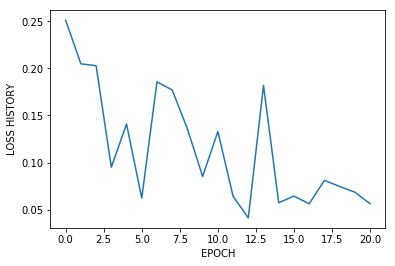

In [9]:
# PyTorch: Remember to first initialize the model and optimizer, then load the dictionary locally.
model = NN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load model
PATH = "checkpoints/model_epoch15.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
EPOCH = checkpoint['epoch']
LOSS_HISTORY = checkpoint['loss_history']

# Set model to train mode
model.train()

# Check accuracy on training data with loaded model 
check_accuracy(train_loader, model)

# Train a little bit more
for epoch in range(EPOCH, 21):
    print(f'Epoch: {epoch}.')
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Reshape to correct shape
        data = data.reshape(data.shape[0], -1) # here i can use data.flatten(start_dim=1) to reshape
        
        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad() # Set gradient to zero on each batch
        loss.backward()

        # Gradient descent or Adam step
        optimizer.step()    

    LOSS_HISTORY.append(loss.clone().detach().cpu().numpy())

# Check accuracy on training data with model more trained  
check_accuracy(train_loader, model)

# Print loss history
plt.plot(LOSS_HISTORY)
plt.ylabel('LOSS HISTORY')
plt.xlabel('EPOCH')
plt.show()




## GPU memory utilization estimation

In [5]:
# total consumed GPU memory = GPU memory for parameters x 2 (one for value, one for gradient) + GPU memory for storing forward and backward responses + inputs
# https://discuss.pytorch.org/t/gpu-memory-estimation-given-a-network/1713

# Mi estimation of memory is (using summary(model, (64,784))):
#   39760 params = 0.15 MB, ok
#   input size = 0.19 MB, ok
#   forward/backward pass size = 0.03 MB
#   (according to summary) estimated total size = 0.37 MB

# OBS: th estiamted total size if for params, input size, and forward pass. Not the loss
# neither the back pass. Total is 0.80 MB, so the back pass is the same as estimated total size

# OBS2: Each batch of images is 200704 bytes, so each entry is 4 bytes (64*28*28 = 200704bytes)


# Now i will check if that is accurate. Have to estimate the memory for initialization of CUDA
before_allocated = torch.cuda.memory_allocated(0)/1024**2
befores_cached = torch.cuda.memory_reserved(0)/1024**2

# The allocated memory is the memory that is currently used to store Tensors on the GPU.
# The cached memory is the memory that is currently used on the GPU by pytorch (as can be seen in nvidia-smi).

print('Pre-training Memory Usage:')
print(f'\t Allocated: {before_allocated:.10f} MB.')
print(f'\t Cached: {befores_cached:.10f} MB.')

input_size = 784
hidden_size = 50 
num_classes = 10
learning_rate=0.001
batch_size = 64

# Forward + backward pass
model = NN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

images, labels = iter(train_loader).next()
images = images.to(device)

labels = labels.to(device)

images = images.flatten(start_dim=1)

scores = model(images)
loss = criterion(scores, labels)

optimizer.zero_grad()
loss.backward()

optimizer.step()    


after_allocated = torch.cuda.memory_allocated(0)/1024**2
after_cached = torch.cuda.memory_reserved(0)/1024**2
print('After Memory Usage:')
print(f'\t Allocated: {after_allocated:.10f} MB. Difference: {(after_allocated - before_allocated)} MB.')
print(f'\t Cached: {after_cached:.10f} MB. Difference: {(after_cached - befores_cached)} MB.')


Pre-training Memory Usage:
	 Allocated: 0.0000000000 MB.
	 Cached: 0.0000000000 MB.
After Memory Usage:
	 Allocated: 0.8061523438 MB. Difference: 0.80615234375 MB.
	 Cached: 2.0000000000 MB. Difference: 2.0 MB.


In [2]:
# CUDA INITIALIZATION MEMORY

before_allocated = torch.cuda.memory_allocated(0)/1024**2
befores_cached = torch.cuda.memory_reserved(0)/1024**2

print('Pre-training Memory Usage:')
print(f'\t Allocated: {before_allocated:.10f} MB.')
print(f'\t Cached: {befores_cached:.10f} MB.')

a=torch.cuda.FloatTensor(1)

after_allocated = torch.cuda.memory_allocated(0)/1024**2
after_cached = torch.cuda.memory_reserved(0)/1024**2
print('After Memory Usage:')
print(f'\t Allocated: {after_allocated:.10f} MB. Difference: {(after_allocated - before_allocated)} MB.')
print(f'\t Cached: {after_cached:.10f} MB. Difference: {(after_cached - befores_cached)} MB.')

# 0.00048828125 MB

Pre-training Memory Usage:
	 Allocated: 0.0000000000 MB.
	 Cached: 0.0000000000 MB.
After Memory Usage:
	 Allocated: 0.0004882812 MB. Difference: 0.00048828125 MB.
	 Cached: 2.0000000000 MB. Difference: 2.0 MB.


OBS: pytorch estimates one pass of the newtork in 0.80MB, but with nvidia-smi i get from 400MB to 800MB aprox, i have to check this. 
Just initializing cuda, with nvidia-smi I get around 456 MB of difference


### CUDA memory management: https://pytorch.org/docs/master/notes/cuda.html#cuda-memory-management